<a href="https://colab.research.google.com/github/lehai-ml/fine-tune-llm/blob/main/fine-tune-llm-unsloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning LLM

LLMs currently have billions of parameters. I'm interested in understanding how you can fine-tune the LLM to fit a specific task. Fine-tuning an LLM from scratch is resource-intensive, and if not done appropriately, it could lead to the model losing its base language understanding.

Parameter-efficient finetuning (PEFT) is a class of fine-tuning method. Low-Rank Approximation (LoRA) is a type of PEFT method that can achieve with minimal computational resources. PEFT methods can be defined into three subtypes [[1]](https://medium.com/@mujahidabdullahi1992/an-introduction-to-lora-unpacking-the-theory-and-practical-implementation-e665c5d78295):
1. Selective - only a subset of weights are fine-tuned
2. Reparametrisation - creates a low-dimensional representation of a specific module in the original LLM
3. Additive - adding a new modules for fine-tuning. These modules are further trained to incorporate knowledge of the new domain into the pre-trained LLM.

## Lower Rank Approximation method

Put simply, previous researches found that a trained LLM to contain many redundant parameters and can function just as good with less weights (referred to as "intrinsic rank").

If the weight matrix update is $W$, then it can be represented by two lower rank matrices, $A$ and $B$, such that $A$ is the lower dimension matrix and $B$ is the linear transformation of $A$ to the higher dimension, i.e.
$\Delta W = AB$

Case in point, if you have 500 x 400 matrix, then it means you have 200000 parameters, but if we can decompose it into two lower rank matrices of 500 x 4 & 4 x 100, we only have to fine tune 2400 parameters.

In terms of which weights to tune (and which to freeze) and what rank to set, the authors found that applying LoRA on several attention weights with a low rank can perform better than applying LoRA on a single attention weight with a high rank [[2]](https://arxiv.org/pdf/2106.09685).

LoRA can be used in several context:
1. Text classification - adpating a model to classify text into predefined categories, such as sentiment analysis or topic classification
2. Question Answering: Fine-tuning the model to provide accurate answers to questions based on a given context or dataset
3. Named Entity Recognition: Customising the model to identify and classify entities (like names, dates, locations) in text.
4. Translation: improving the translation capabilities
5. Dialogue systems: tailoring the response / output of the chatbots.

# Question and Answering

Let's start with the BERT question and answering model. The point of this model is given a passage of text, the user can ask a question and can expect an highly accurate answer based on that text.





In [2]:
from transformers import pipeline

qa_model = pipeline("question-answering")
question = "Where do I live?"
context = "My name is Merve and I live in İstanbul."
qa_model(question = question, context = context)
## {'answer': 'İstanbul', 'end': 39, 'score': 0.953, 'start': 31}


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


{'score': 0.9538118243217468, 'start': 31, 'end': 39, 'answer': 'İstanbul'}

In [1]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import warnings
warnings.simplefilter("ignore")

weight_path = "kaporter/bert-base-uncased-finetuned-squad"
# loading tokenizer
tokenizer = BertTokenizer.from_pretrained(weight_path)
#loading the model
model = BertForQuestionAnswering.from_pretrained(weight_path)


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [1]:
from datasets import load_dataset
from datasets import load_dataset
from peft import PeftModel, PeftConfig, LoraConfig, TaskType, get_peft_model
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


model= AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", id2label=id2label, label2id=label2id)
dataset = load_dataset("rotten_tomatoes")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Invalid pattern: '**' can only be an entire path component

In [ ]:
!pip install trl

In [ ]:
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.

In [ ]:
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


<ipython-input-2-47bd71ed1ebe>:4: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth.chat_templates import get_chat_template


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("Amod/mental_health_counseling_conversations")


README.md:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

combined_dataset.json:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [ ]:
data = dataset['train']

In [ ]:
data = dataset['train'].to_pandas()

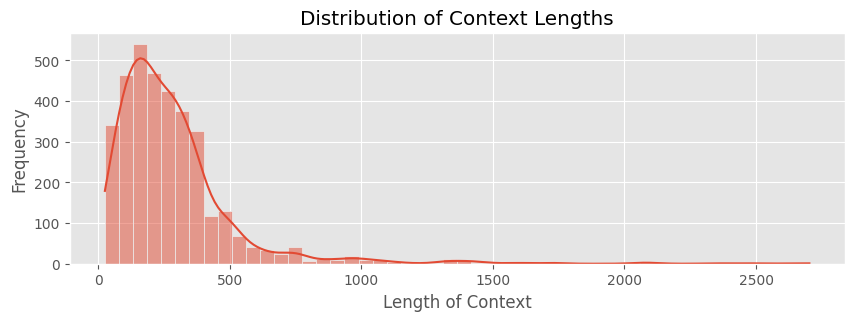

In [ ]:
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()



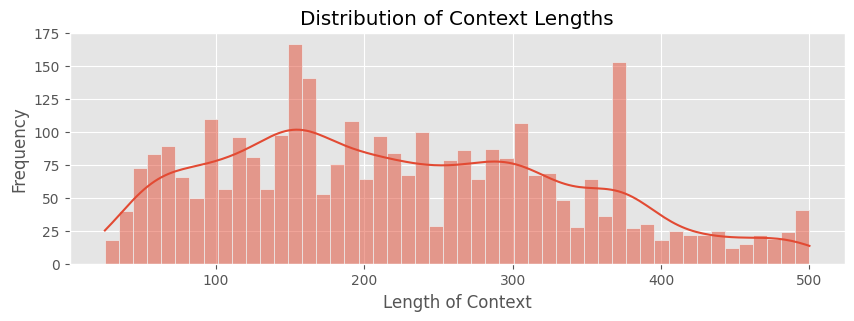

In [ ]:
filtered_data = data[data['Context_length'] <= 500]

ln_Context = filtered_data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


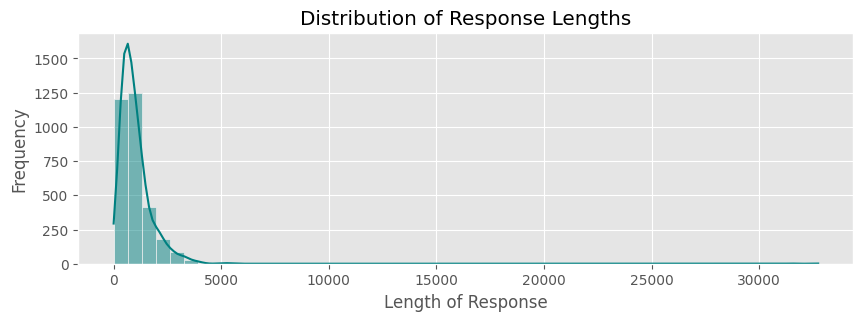

In [ ]:
ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


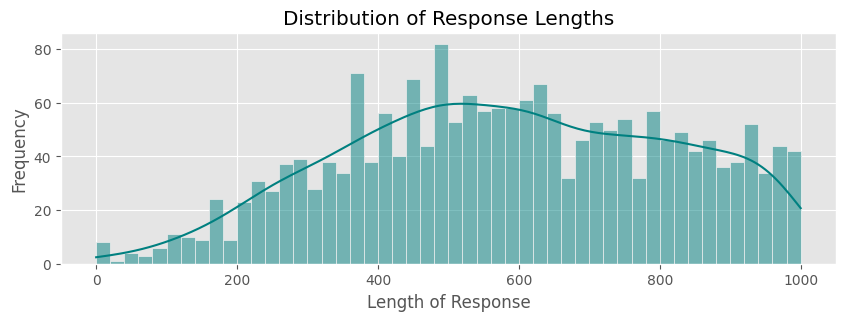

In [ ]:
filtered_data = filtered_data[ln_Response <= 1000]

ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


In [ ]:
filtered_data_sampled = filtered_data.sample(100)

In [ ]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())


==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [ ]:
data_prompt = """Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [ ]:
training_data = Dataset.from_pandas(filtered_data_sampled)
training_data = training_data.map(formatting_prompt, batched=True)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
torch.cuda.empty_cache()

In [ ]:
training_data

Dataset({
    features: ['Context', 'Response', 'Context_length', '__index_level_0__', 'text'],
    num_rows: 100
})

In [ ]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        num_train_epochs=10,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()


Converting train dataset to ChatML (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 10 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Step,Training Loss
1,2.852800
2,2.817400
3,2.743100
4,2.817200
5,2.478300
6,2.298500
7,2.363800
8,2.002700
9,2.020500
10,1.922100


TrainOutput(global_step=60, training_loss=1.1540144853293897, metrics={'train_runtime': 139.4669, 'train_samples_per_second': 7.17, 'train_steps_per_second': 0.43, 'total_flos': 1317328886046720.0, 'train_loss': 1.1540144853293897})

In [ ]:
text="I'm going through some things with my feelings and myself. \
I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. \
I've never tried or contemplated suicide. \
I've always wanted to fix my issues, but I never get around to it. \
How can I change my feeling of being worthless to everyone?"



In [ ]:
model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 5020, use_cache = True)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
print("Answer of the question is:", answer)


Answer of the question is: 
It sounds like you are at the beginning stages of developing resilience. Resilience is your ability to cope with stress and still be able to function. In your life experience you have learned that you are not worthy of love and that you are a horrible person. Your experience has also taught you that if you have feelings of worthlessness, shame and sadness, that you will always feel these ways. Based on this analysis, you would probably have no desire to learn new ways of feeling other feelings. Your natural tendency would be to just accept these feelings as they show up. This is a valid way of looking at it, but it only tells part of the story. Your other response options are possible and may be more interesting from a mental health perspective. You may be able to feel safe and comfortable with accepting yourself without these feelings. You may be able to feel happy and enjoy life without shame and sadness. Whichever route you choose will be a result of your